# How to calculate and visualize Aerosol Optical Depths (AOD) from MISR

## Summary

## Note

By Cheyenne Land, Walt Baskin

Tested using Python 3.8.10

## 1. Setup

In [ ]:
from pyhdf.SD import SD, SDC
import numpy as np
from matplotlib import pyplot as PLT
import cartopy.crs as ccrs

## 2. Read in data, with the MIL3YAE file that you have downloaded

In [ ]:
data_file = 'MISR_AM1_CGAS_2016_F15_0031.hdf'
hdf = SD(data_file, SDC.READ)
ds = hdf.datasets()
hdfdataobject = hdf.select('Optical depth average')

## 3. Slice the data

by [Lat, Lon, Optical Depth, Band, Particle Type]

Before conducting the histogram equalizatoin, slice the data with
a value in each dimension of your choosing

MISR camera bands: 0 = Blue (443 nm), 1 = Green (555 nm), 2 = Red (670 nm).

Select one particle type and optical depth range to graph

Optical Depth Range: 0 = All, 1 = <0.05, 2 = 0.05 - 0.15, 3 = 0.15 - 0.25, 4 = 0.25 - 0.4,
5 = 0.4 - 0.6, 6 = 0.6 - 0.8, 7 = 0.8 - 1.0, 8 = > 1.0

Particle Type: 0 = All, 1 = Small Particle (<0.35 micron radius), 2 = Medium Particle (0.35 - 0.7 micron radius), 3 = Large Particle (>0.7 micron radius), 4 = Spherical Particle,
5 = Nonspherical particle

For more informaion go to [https://asdc.larc.nasa.gov/documents/misr/dps/dps.html]

In [ ]:
hdfdata = hdfdataobject.get()
blueband = hdfdata[:,:,0,0,1]
greenband = hdfdata[:,:,0,1,1]
redband = hdfdata[:,:,0,2,1]

## 4. Stack the blue, green and red bands to use the histogram equalization function

In [ ]:
data = np.dstack((blueband,greenband,redband))

## 5. Histogram Equalization

Histogram Equalization is a technique that spreads out the most frequent intensity values
to improve the contrast in images (Sudhakar). The histogram equalization process also relies on the
cumulative distributive function (cdf). The cdf describes the probabliity that a variable takes a value less than or equal to x (COSTE).
Using this function for the MISR Aerosol Optical Depth script will allow the user to have a better visualization of the data.

Sudhakar, Shreenidhi. “Histogram Equalization.” Medium, Towards Data Science, 30 Jan. 2021, towardsdatascience.com/histogram-equalization-5d1013626e64.

COSTE, Arthur. “Project 1 : HISTOGRAMS.” Image Processing, 5 Sept. 2012, www.sci.utah.edu/~acoste/uou/Image/project1/Arthur_COSTE_Project_1_report.html.


In [ ]:
nbr_bins = 256
data_min = 0.0
data_max = 1.0
data = np.where(data < data_min, data_min, data)
data = np.where(data > data_max, data_max, data)
''' histogram equalization '''
datahist,bins = np.histogram(data.flatten(),nbr_bins, density=True)
''' cumulative distribution function '''
cdf = datahist.cumsum()
cdf_normalized = cdf / cdf.max()
''' use linear interpolation of cdf to find new pixel values '''
out_data = np.interp(data.flatten(),bins[:-1],cdf_normalized)
''' scale between 0 and 1 '''
out_data_min = np.min(out_data)
out_data_max = np.max(out_data)
data_range = out_data_max - out_data_min
''' normalize '''
out_data = ((out_data - out_data_min)/data_range)
oda_data = out_data.reshape(data.shape)

## 6. Turn the -9999.0 into a NaN

In [ ]:
masked_data = np.ma.masked_where(oda_data <= 0, oda_data)
final_oda_data = oda_data.copy()
final_oda_data[masked_data <= 0] = np.nan

## 7. Convert array type from float64 to the datas original data type, float32

In [ ]:
final32 = np.float32(final_oda_data)

## 8. Select a band to plot

0 = Blue (443 nm), 1 = Green (555 nm), 2 = Red (670 nm)

In [ ]:
greenbandfinal = final32[:,:,1]

## 9. Plot figure

In [ ]:
PLT.figure(figsize=(7.20,3.60))
lons = np.linspace(-179.75,179.75, 720)
lats = np.linspace(89.75,-89.75, 360)
ax = PLT.axes(projection=ccrs.PlateCarree())
im = PLT.contourf(lons, lats, greenbandfinal, 300, cmap=PLT.get_cmap('jet'),
              transform=ccrs.PlateCarree())
ax.coastlines()
PLT.title('MISR_AM1_CGAS_2016_F15_0031_555nm_SMALL_PARTICLE', fontsize=8)
cb = PLT.colorbar(im, ticks = [0 , 1 ] , shrink=0.83)
cb.set_label('Optical Depth Average', fontsize=8)

## 10. Save the figure in your current directory

In [1]:
# PLT.savefig("MISR_AM1_CGAS_2016_F15_0031_555nm_SMALL_PARTICLE.jpg", dpi=200)
# PLT.close()

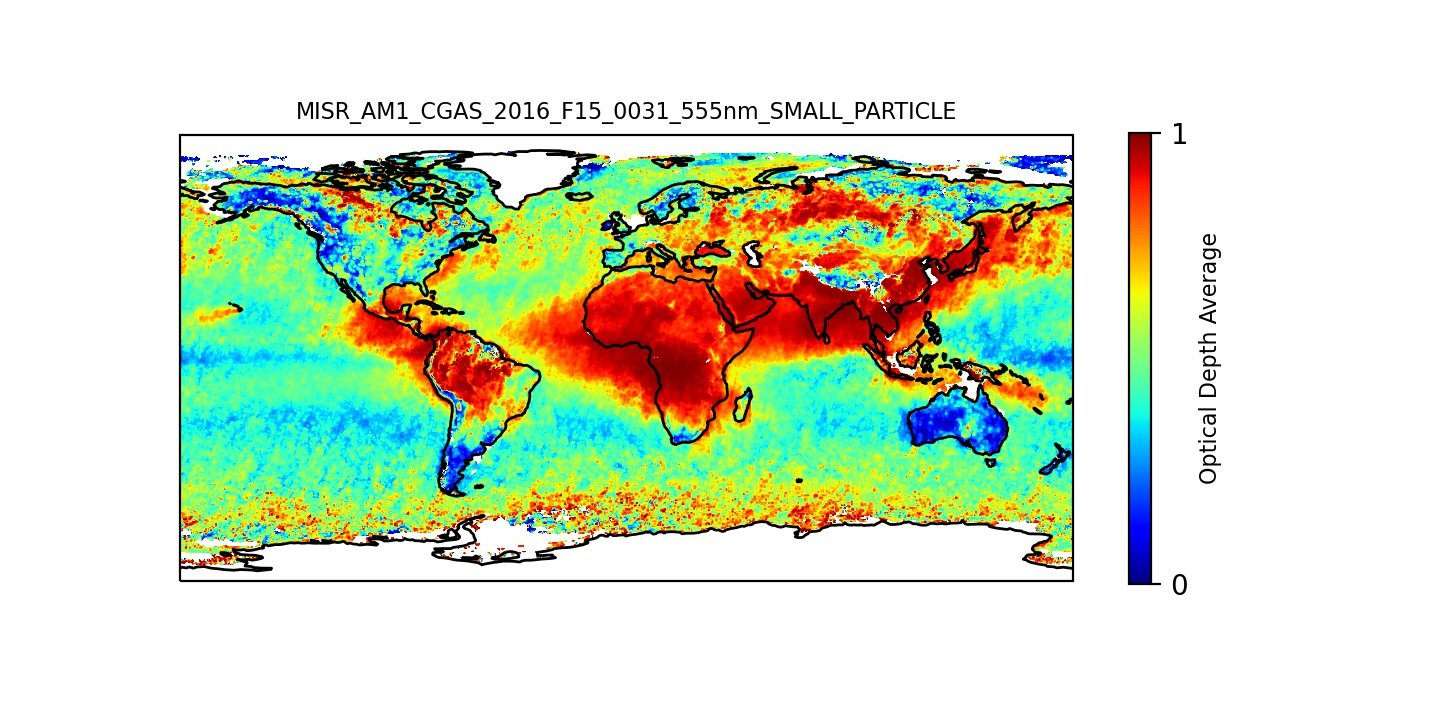